This notebook analyses the data and produces some plots run by run_simulation.py

In [1]:
import NLDv3
import NLD2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.linalg as spl
from scipy.optimize import root
from scipy.optimize import root_scalar
from scipy import special
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

In [2]:
def add_slope_marker(ax, xy, slope, length_decades=0.5, text='', text_offset=(0.05, 0.1), **kwargs):
    """
    Adds a short slope marker line and label to a log-log plot.
    
    ax           -- matplotlib axes object
    xy           -- (x, y) tuple: anchor point
    slope        -- float: slope value (in y ~ x^slope)
    length_decades -- float: how long in log10(x) (default=0.5)
    text         -- str: annotation text to place near the marker
    text_offset  -- (dx,dy): relative offset for label (in data)
    kwargs       -- extra args for ax.plot (color, lw, etc)
    """
    # start/end in log space
    x0, y0 = xy
    x1 = x0 * 10**length_decades
    y1 = y0 * 10**(length_decades * slope)
    ax.plot([x0, x1], [y0, y1], **kwargs)
    # midpoint for label position
    xm = x0 * (10**(length_decades/2))
    ym = y0 * (10**((length_decades/2) * slope))
    # angle for label
    angle = np.degrees(np.arctan(slope))
    # text offset
    tx = xm * (1+text_offset[0])
    ty = ym * (1+text_offset[1])
    ax.text(tx, ty, text, rotation=angle,
            va='bottom', ha='left', color=kwargs.get('color', 'k'))

In [3]:
#Figure parameters for paper
_new_black = '#373737'
params = {
   'axes.labelsize': 8,
   'axes.labelpad':-0.2,
   'font.size': 8,
   'legend.fontsize': 8,
   'legend.handlelength' : 1,
   'legend.handletextpad' : 0.2,
   'legend.markerscale': 0.75,
   'legend.framealpha' : 0.5,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'lines.markersize':4,
   'lines.linewidth': 0.75,
   'lines.markeredgewidth': 0.4,
   'markers.fillstyle' : 'none',
   'text.usetex': False,
   # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black
   }
colorlin = 'C0'
colorsqrt = 'C1'
plt.style.use('default')
plt.rcParams.update(params)

In [4]:
#1D simulations
query_param = {
    'L': 1000,
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_DLogspace_updated.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
data=[];
for group_id in matches['group_id']:
    data.append(NLDv3.load_simulation_data(group_id,saveFile='DLogspace.h5'))

Found runs:        L   BC  t0  Dn          Db  gamma  alpha  beta  dt  accuracyX  \
1   1000  Dir   0   1    0.010000      1      1     1   0       0.35   
2   1000  Dir   0   1    0.013738      1      1     1   0       0.35   
3   1000  Dir   0   1    0.018874      1      1     1   0       0.35   
4   1000  Dir   0   1    0.025929      1      1     1   0       0.35   
5   1000  Dir   0   1    0.035622      1      1     1   0       0.35   
6   1000  Dir   0   1    0.048939      1      1     1   0       0.35   
7   1000  Dir   0   1    0.067234      1      1     1   0       0.35   
8   1000  Dir   0   1    0.092367      1      1     1   0       0.35   
9   1000  Dir   0   1    0.126896      1      1     1   0       0.35   
10  1000  Dir   0   1    0.174333      1      1     1   0       0.35   
11  1000  Dir   0   1    0.239503      1      1     1   0       0.35   
12  1000  Dir   0   1    0.329034      1      1     1   0       0.35   
13  1000  Dir   0   1    0.452035      1      1     

In [5]:
#Load data in 2d
#2d simulations for analysis as a function of D
query_param = {
    'L': 1500,    
}

#Identify all the matches with those parameters and print their IDs
matches2d = NLD2d.find_simulations_by_param(query_param, csvFile = "lookup_2d.csv")
print("Found runs:", matches2d)

# Load and use the simulation data for each run
data2d=[];
for group_id in matches2d['group_id']:
    data2d.append(NLD2d.load_simulation_data(group_id,saveFile='2d.h5'))

Found runs:        L   BC   t0   Dn          Db  gamma  alpha  method     K    nm  beta  \
19  1500  Dir  0.0  1.0  100.000000      1      1  linear  0.05  0.05     1   
20  1500  Dir  0.0  1.0   63.095734      1      1  linear  0.05  0.05     1   
21  1500  Dir  0.0  1.0   39.810717      1      1  linear  0.05  0.05     1   
22  1500  Dir  0.0  1.0   25.118864      1      1  linear  0.05  0.05     1   
23  1500  Dir  0.0  1.0   15.848932      1      1  linear  0.05  0.05     1   
24  1500  Dir  0.0  1.0   10.000000      1      1  linear  0.05  0.05     1   
25  1500  Dir  0.0  1.0    6.309573      1      1  linear  0.05  0.05     1   
26  1500  Dir  0.0  1.0    3.981072      1      1  linear  0.05  0.05     1   
27  1500  Dir  0.0  1.0    2.511886      1      1  linear  0.05  0.05     1   
28  1500  Dir  0.0  1.0    1.584893      1      1  linear  0.05  0.05     1   
29  1500  Dir  0.0  1.0    1.000000      1      1  linear  0.05  0.05     1   
30  1500  Dir  0.0  1.0    0.630957     

In [6]:
#2D simulation for power-law extraction (long times)
query_param = {
    'L': 2000,
    'Db': 0.2
    
}
query_param2 = {
    'L': 10000,
}

#Identify all the matches with those parameters and print their IDs
matches2d = NLD2d.find_simulations_by_param(query_param, csvFile = "lookup_2d.csv")
print("Found runs:", matches2d)

# Load and use the simulation data for each run
data2d_long=[];
for group_id in matches2d['group_id']:
    data2d_long.append(NLD2d.load_simulation_data(group_id,saveFile='2d.h5'))

#Identify all the matches with those parameters and print their IDs
matches2d_2 = NLD2d.find_simulations_by_param(query_param2, csvFile = "lookup_2d.csv")
print("Found runs:", matches2d_2)

# Load and use the simulation data for each run
for group_id in matches2d_2['group_id']:
    data2d_long.append(NLD2d.load_simulation_data(group_id,saveFile='2d.h5'))


#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_revisions.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
data_long=[];
for group_id in matches['group_id']:
    data_long.append(NLDv3.load_simulation_data(group_id,saveFile='revisions.h5'))

#Identify all the matches with those parameters and print their IDs
matches2 = NLDv3.find_simulations_by_param(query_param2, csvFile = "lookup_revisions.csv")
print("Found runs:", matches2)

# Load and use the simulation data for each run
for group_id in matches2['group_id']:
    data_long.append(NLDv3.load_simulation_data(group_id,saveFile='revisions.h5'))


Found runs:        L   BC   t0   Dn   Db  gamma  alpha  method     K    nm  beta   dt  \
41  2000  Dir  0.0  1.0  0.2      1      1  linear  0.05  0.05     1  0.0   

    accuracyX  accuracyT  n0                                param_hash  \
41       0.35       0.35   1  55f6bfab9118292d12a1de2141929b657e790063   

          timestamp                                           group_id  
41  20251203T155704  55f6bfab9118292d12a1de2141929b657e790063_20251...  
Found runs:         L   BC   t0   Dn   Db  gamma  alpha  method     K    nm  beta   dt  \
40  10000  Dir  0.0  1.0  5.0      1      1  linear  0.05  0.05     1  0.0   

    accuracyX  accuracyT  n0                                param_hash  \
40       0.35       0.35   1  a9a324c051741964d944b15d54ab86a119eea621   

          timestamp                                           group_id  
40  20251202T183742  a9a324c051741964d944b15d54ab86a119eea621_20251...  
Found runs:         L   BC   t0   Dn   Db  gamma  alpha  method     K    n

# Figure 1: Total biomass and profiles

In [7]:
data2d = sorted(data2d, key=lambda x: x['param']['Db'])

In [8]:
D2d = np.zeros(len(data2d))
for index,elem in enumerate(data2d):
    D2d[index] = elem['param']['Db']

In [9]:
edgefit_data2d = NLD2d.edgefit_dataset(data2d,r2_threshold=0.9)
linear_edgefit_data2d = NLD2d.linear_edgefit_dataset(data2d,r2_threshold=0.9)

In [10]:
#Unpack the data
#2d data
V2d = np.zeros(len(linear_edgefit_data2d))
R22_2d = np.zeros(len(linear_edgefit_data2d))
for index,elem in enumerate(linear_edgefit_data2d):
    V2d[index] = elem['xi']
    R22_2d[index] = elem['r2']
chi2d = np.zeros(len(edgefit_data2d))
R2_2d = np.zeros(len(edgefit_data2d))
for index,elem in enumerate(edgefit_data2d):
    chi2d[index] = elem['xi']/2
    R2_2d[index] = elem['r2']

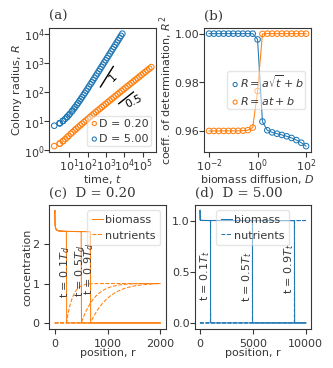

In [11]:
ind1 = 0
ind2 = 1
slice1 = 5
slice2 = 5
#Inline 2 column
#fig = plt.figure(figsize=(6.75, 2))
#subfigs = fig.subfigures(1, 2,wspace=-0.05)
#ax0 = subfigs[0].subplots(1,2)
#subfigs[0].subplots_adjust(wspace=0.55)
#ax1 = subfigs[1].subplots(1,2,sharey=True)
#subfigs[1].subplots_adjust(wspace=0.25)

#2*2 figure
fig = plt.figure(figsize=(3.375, 3.375))
subfigs = fig.subfigures(2, 1,hspace=0.1)
fig.subplots_adjust(hspace=0.3, wspace=0.25)
ax0 = subfigs[0].subplots(1,2)
subfigs[0].subplots_adjust(wspace=0.45)
ax1 = subfigs[1].subplots(1,2,sharey=False)
subfigs[1].subplots_adjust(wspace=0.25)

xoffset=150


#Total biomass on log scale
#Select points to plot on a log-scale so it looks pretty
Nplot = 50
time1 = data2d_long[ind1]['time']
time2 = data2d_long[ind2]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
mask2 = time2 > 0
time2 = time2[mask2]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
log_times2 = np.logspace(np.log10(time2.min()), np.log10(time2.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1,side='left')
indices1 = np.clip(indices1, 0, len(time1) - 1)
indices2 = np.searchsorted(time2, log_times2,side='left')
indices2 = np.clip(indices2, 0, len(time2) - 1)
#Plot on log scale
ax0[0].scatter(time1[indices1],data2d_long[ind1]['front_position'][indices1],color = colorsqrt,label=f"D = {data2d_long[ind1]['param']['Db']:.2f}")
ax0[0].scatter(time2[indices2],data2d_long[ind2]['front_position'][indices2],color = colorlin,label=f"D = {data2d_long[ind2]['param']['Db']:.2f}")
ax0[0].set_xscale('log')
ax0[0].set_yscale('log')
#ax0[0].set_xlim(10,data[ind2]['time'][-1])#10**3.5)#
#ax0[0].set_ylim(10,data[ind1]['total_biomass'][-1])
ax0[0].set_xlabel(r"time, $t$")
ax0[0].set_ylabel(r"Colony radius, $R$",labelpad=-0.2)
ax0[0].set_xticks([10,100,1000,10000,100000])
ax0[0].minorticks_off()
ax0[0].tick_params(axis='both', which='major', pad=0)

# ----------- Add power-law reference lines -------------
add_slope_marker(ax0[0], xy=(500, 150), slope=1, length_decades=0.7, text_offset=(0, -0.4), text=r"1", color='k', lw=1)
add_slope_marker(ax0[0], xy=(5000, 40), slope=0.5, length_decades=0.8, text_offset=(-0.25, -0.6), text=r"0.5", color='k', lw=1)
ax0[0].legend(loc='best',handletextpad=-0.1,borderpad=0.2,markerscale=0.75,frameon=True)
ax0[0].set_title('(a)',fontfamily='serif',loc='left')

#Plots of the R^2 for linear and quadratic fits
ax0[1].set_xscale('log')
spline = make_interp_spline(D2d, R2_2d, k=11)
spline2 = make_interp_spline(D2d, R22_2d, k=11)
# Generate smooth x (higher resolution)
x_smooth = np.linspace(D2d.min(), D2d.max(), 500)
y_smooth1 = spline(x_smooth)
y_smooth2 = spline2(x_smooth)
ax0[1].scatter(D2d, R2_2d,label=r'$R = a\sqrt{t}+b$')
ax0[1].scatter(D2d,R22_2d,label=r'$R = at+b$')
#ax[0,1].plot(x_smooth,y_smooth1,color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth2,color=colorsqrt)
ax0[1].plot(D2d,spline(D2d),color=colorlin)
ax0[1].plot(D2d,spline2(D2d),color=colorsqrt)
ax0[1].set_xlabel(r'biomass diffusion, $D$')
ax0[1].set_ylabel(r'coeff. of determination, $R^2$',labelpad=-0.4)
ax0[1].set_xticks([10**(-2),1,100])
ax0[1].legend(loc='best',handletextpad=-0.1,borderpad=0.2,markerscale=0.75,frameon=True)
ax0[1].set_title('(b)',fontfamily='serif',loc='left')
ax0[1].tick_params(axis='both', which='major', pad=0)

#Plots of the profiles for biomass
Np1 = len(data2d_long[ind1]['biomass_snapshots'])
Np2 = len(data2d_long[ind2]['biomass_snapshots'])
for i in [1,5,9]:
    # For ax[1,1]
    idx1 = i * int((Np1-1)/10)
    profile1 = data2d_long[ind1]['biomass_snapshots'][idx1]
    pos1 = data2d_long[ind1]['position']
    time1 = data2d_long[ind1]['time_snapshots'][idx1]
    
    max1 = np.max(profile1)
    front_idx1 = np.where(profile1 < 0.5*max1)[0][0]
    x_label1 = pos1[front_idx1]-xoffset
    y_label1 = profile1[front_idx1]
    
    if i==1:
        ax1[0].plot(pos1,profile1,color=colorsqrt,label=r'biomass')
        ax1[0].plot(pos1,data2d_long[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed',label=r'nutrients')
    else:
        ax1[0].plot(pos1,profile1,color=colorsqrt)
        ax1[0].plot(pos1,data2d_long[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed')
    ax1[0].text(x_label1, y_label1, fr"t = 0.{i}$T_d$", rotation=90, va='center', ha='left')

    # For ax[1,0]
    idx2 = i * int((Np2-1)/10)
    profile2 = data2d_long[ind2]['biomass_snapshots'][idx2]
    pos2 = data2d_long[ind2]['position']
    time2 = data2d_long[ind2]['time_snapshots'][idx2]

    max2 = np.max(profile2)
    front_idx2 = np.where(profile2 < 0.5*max2)[0][0]
    x_label2 = pos2[front_idx2] -8*xoffset
    y_label2 = profile2[front_idx2]
    
    if i==1:
        ax1[1].plot(pos2,profile2,color=colorlin,label=r'biomass')
        ax1[1].plot(pos2,data2d_long[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed',label=r'nutrients')
    else:
        ax1[1].plot(pos2,profile2,color=colorlin)
        ax1[1].plot(pos2,data2d_long[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed')
    ax1[1].text(x_label2, y_label2, f"t = 0.{i}$T_t$", rotation=90, va='center', ha='left')

    #ax.plot(data[ind]['position'],data[ind]['nutrient_snapshots'][-1])
#ax.set_xlim(0,100)
ax1[0].set_xlabel(r"position, r")
ax1[1].set_xlabel(r"position, r")
ax1[1].legend(handlelength=1,handletextpad=0.2, loc='upper center')
ax1[0].legend(handlelength=1,handletextpad=0.2,loc='upper right')
#ax[1, 1].get_shared_y_axes().join(ax[1, 1], ax[1, 0])
ax1[0].set_ylabel(r"concentration",labelpad=-0.2)
ax1[1].set_title(f"(d)  D = {data2d_long[ind2]['param']['Db']:.2f}",fontfamily='serif',loc='left')
ax1[0].set_title(f"(c)  D = {data2d_long[ind1]['param']['Db']:.2f}",fontfamily='serif',loc='left')
ax1[0].set_xticks([0,1000,2000])
#ax1[1].set_xticks([0,500,1000,1500])
ax1[1].set_yticks([0,0.5,1])
ax1[1].tick_params(axis='y', which='major', pad=0)


#fig.savefig('./Figures/fig1_2d.pdf',format='pdf',bbox_inches='tight',pad_inches=0)

# Figure 2 : Velocity, ODE vs PDE

In [12]:
D = np.zeros(len(data))
for index,elem in enumerate(data):
    D[index] = elem['param']['Db']

In [13]:
#Load the shorter lengths data
query_param = {
    'L': 500,
    'method' : 'linear'
}

#Identify all the matches with those parameters and print their IDs
matches_small = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_method_Logscale.csv")
print("Found runs:", matches_small)

# Load and use the simulation data for each run
data_small=[];
for group_id in matches_small['group_id']:
    data_small.append(NLDv3.load_simulation_data(group_id,saveFile='method_Logspace.h5'))

Found runs:       L   BC   t0   Dn          Db  gamma  alpha  method  beta   dt  \
0   500  Dir  0.0  1.0    0.010000      1      1  linear     1  0.0   
1   500  Dir  0.0  1.0    0.013738      1      1  linear     1  0.0   
2   500  Dir  0.0  1.0    0.018874      1      1  linear     1  0.0   
3   500  Dir  0.0  1.0    0.025929      1      1  linear     1  0.0   
4   500  Dir  0.0  1.0    0.035622      1      1  linear     1  0.0   
5   500  Dir  0.0  1.0    0.048939      1      1  linear     1  0.0   
6   500  Dir  0.0  1.0    0.067234      1      1  linear     1  0.0   
7   500  Dir  0.0  1.0    0.092367      1      1  linear     1  0.0   
8   500  Dir  0.0  1.0    0.126896      1      1  linear     1  0.0   
9   500  Dir  0.0  1.0    0.174333      1      1  linear     1  0.0   
10  500  Dir  0.0  1.0    0.239503      1      1  linear     1  0.0   
11  500  Dir  0.0  1.0    0.329034      1      1  linear     1  0.0   
12  500  Dir  0.0  1.0    0.452035      1      1  linear     1  0

In [14]:
fit_data = NLDv3.linearfit_dataset(data)
fit_data_small = NLDv3.linearfit_dataset(data_small)
fit_data_square = NLDv3.quadraticfit_dataset(data)
fit_data_sqrt = NLDv3.sqrtfit_dataset(data)
edgefit_data = NLDv3.edgefit_dataset(data)

In [15]:
#Unpack the data
V = np.zeros(len(fit_data))
V_small = np.zeros(len(fit_data_small))
R2 = np.zeros(len(fit_data))
for index,elem in enumerate(fit_data):
    V[index] = elem['velocity']
    R2[index] = elem['r2']
for index,elem in enumerate(fit_data_small):
    V_small[index] = elem['velocity']
K = np.zeros(len(fit_data))
R22 = np.zeros(len(fit_data))
for index,elem in enumerate(fit_data_square):
    K[index] = elem['K']
    R22[index] = elem['r2']
chi = np.zeros(len(fit_data))
for index,elem in enumerate(edgefit_data):
    chi[index] = elem['xi']/2
kappa = np.zeros(len(fit_data_sqrt))
for index,elem in enumerate(fit_data_sqrt):
    kappa[index] = elem['xi']/2

In [16]:
#Load the ODE data
ODE_Data = np.load('a_D_coarse_survey_beta_1.npz')

In [17]:
v_th = ODE_Data['vs']
D_th = ODE_Data['Ds']
alphas = ODE_Data['alphas']
ind_th = np.where(alphas == 1)[0][0]

In [18]:
#Add the theoretical values
def f(v,a,d=0):
    return v**2*(0.5+(0.25+v**-2)**0.5)**(1+a)-d
D_an = np.logspace(-2,2,50)
v_an = np.zeros(len(D_an))
for j in range(len(D_an)):
    sol = spo.root_scalar(f, x0=10, method='secant', args=(1,D_an[j])) # large initial guess to get the large v solution
    v_an[j] = sol.root
    if abs(f(v_an[j],1,D_an[j]))>0.01: v_an[j]=0

Text(0, 0.5, 'velocity, $v$')

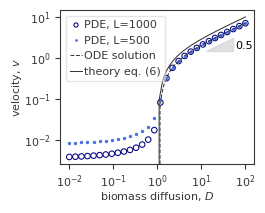

In [19]:
#Plot the velocity
fig,ax = plt.subplots(figsize=(2.5,2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(D, V,marker='o',label='PDE, L=1000',color='navy')
ax.plot(D, V_small,marker='.',fillstyle='full',linestyle='None',label='PDE, L=500',color='royalblue')
ax.plot(D_th,v_th[ind_th],linestyle='dashed',label='ODE solution',color=_new_black)
ax.plot(D_an,v_an,linestyle='solid',color=_new_black,label='theory eq. (6)')
# Triangle parameters:
alpha=0.5
x0 = 13        # left base point of triangle
width = 4      # triangle width in x (factor)
x1 = x0 * width
y0 = 1.5        # vertical base
y1 = y0 * (x1/x0)**alpha

# Triangle corners in data coordinates
A = (x0, y0)
B = (x1, y0)
C = (x1, y1)

# Draw triangle (using fill, works fine in log-log since coordinates are correct)
triangle = plt.Polygon([A, B, C], color='lightgray', alpha=0.7)
ax.add_patch(triangle)
# (Optional) triangle outline:
#ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], color='k', lw=1)

# Add an annotation for slope
ax.text(x1*1.15, (y0*y1*0.8)**0.5, 
        r'0.5', 
        va='center', ha='left', color='k')
ax.legend()
ax.set_xlabel(r'biomass diffusion, $D$')
ax.minorticks_off()
ax.set_ylabel(r'velocity, $v$')
#fig.savefig('./Figures/fig2-slopemarker.pdf',format='pdf',bbox_inches='tight')

# Figure 3 : Edge and Height in the absorber case

Edge position evolves according to $X_e = 2 \chi \sqrt{t}$

In [20]:
#Inverse the edge diffusion and height relationship in 2d
def target_function_for_inverse(x, y_target):
    """Function whose root we seek to find the inverse."""
    return 1/((np.pi**0.5)*x * np.exp(x**2)*special.erfc(x)) - y_target

def numerical_inverse(y_value, initial_guess=1):
    """Numerically calculates the inverse of original_function for a given y_value."""
    # Find the root of target_function_for_inverse for the given y_value
    sol = root(target_function_for_inverse, initial_guess, args=(y_value,))
    
    if sol.success:
        return sol.x[0]
    else:
        raise ValueError("Root finding failed for the given y_value.")


In [21]:
# Functional relationship between height and expansion in 1d
def height(x):
    den = (x**2)*np.exp(x**2)*(-special.expi(-x**2))
    H = 1/den
    return H

def target_function_for_inverse2d(x, y_target):
    """Function whose root we seek to find the inverse."""
    return height(x) - y_target

def numerical_inverse2d(y_value, initial_guess=1):
    """Numerically calculates the inverse of original_function for a given y_value."""
    # Find the root of target_function_for_inverse for the given y_value
    sol = root(target_function_for_inverse2d, initial_guess, args=(y_value,))
    
    if sol.success:
        return sol.x[0]
    else:
        raise ValueError("Root finding failed for the given y_value.")

In [22]:
#Get height of the colony from data in 2d
mask2d = np.where(D2d<1)[0]
H2d = np.zeros(len(mask2d))
chi_th2d = np.zeros(len(mask2d))
#H_th = np.zeros(len(mask))
time_stamp1 = -1
for i in range(len(H2d)):
    #Compute the height by looking at the maximum around the front
    front_pos1 = data2d[i]['front_position'][10*time_stamp1]
    dx1 = (data2d[i]['position'][2]-data2d[i]['position'][1])
    Npoints1 = int(20/dx1) #Number of points around the front position
    front_pos_ind1 = int(front_pos1/dx1)
    H2d[i] = max(data2d[i]['biomass_snapshots'][time_stamp1][front_pos_ind1-Npoints1:front_pos_ind1+Npoints1])
    chi_th2d[i] = numerical_inverse2d(H2d[i])

In [23]:
#Compute height and theoretical value of edge expansion in 1d
mask = np.where(D<1)[0]
H = np.zeros(len(mask))
H_th = np.zeros(len(mask))
chi_th = np.zeros(len(mask))
for elems in mask:
    H[elems] = data[elems]['total_biomass'][-5]/data[elems]['front_position'][-5]
    chi_th[elems] = numerical_inverse(H[elems])

In [24]:
data2d = sorted(data2d, key=lambda x: x['param']['Db'])

In [25]:
D2d = np.zeros(len(data2d))
for index,elem in enumerate(data2d):
    D2d[index] = elem['param']['Db']

In [26]:
fit_data2d = NLD2d.linearfit_dataset(data2d)
fit_data_sqrt2d = NLD2d.sqrtfit_dataset(data2d)
edgefit_data2d = NLD2d.edgefit_dataset(data2d,r2_threshold=0.9)
linear_edgefit_data2d = NLD2d.linear_edgefit_dataset(data2d,r2_threshold=0.9)
edgefit_data = NLDv3.edgefit_dataset(data,r2_threshold=0.9)
linear_edgefit_data = NLDv3.linear_edgefit_dataset(data,r2_threshold=0.9)

In [27]:
#Unpack the data
#2d data
V2d = np.zeros(len(linear_edgefit_data2d))
R22_2d = np.zeros(len(linear_edgefit_data2d))
for index,elem in enumerate(linear_edgefit_data2d):
    V2d[index] = elem['xi']
    R22_2d[index] = elem['r2']
chi2d = np.zeros(len(edgefit_data2d))
R2_2d = np.zeros(len(fit_data2d))
for index,elem in enumerate(edgefit_data2d):
    chi2d[index] = elem['xi']/2
    R2_2d[index] = elem['r2']

#1d data
V = np.zeros(len(linear_edgefit_data))
R22 = np.zeros(len(linear_edgefit_data))
for index,elem in enumerate(linear_edgefit_data):
    V[index] = elem['xi']
    R22[index] = elem['r2']
chi = np.zeros(len(edgefit_data))
R2 = np.zeros(len(edgefit_data))
for index,elem in enumerate(edgefit_data):
    chi[index] = elem['xi']/2
    R2[index] = elem['r2']

Text(0.0, 1.0, '(b)')

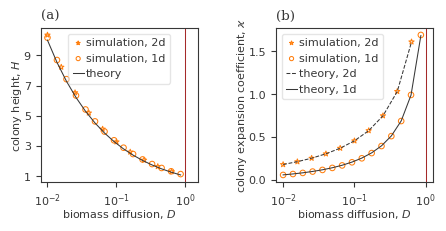

In [28]:
#Figure 3 with 1 and 2d combined, but with only the two panels for eight and edge expansion
#Plot Height as a function of D with the theoretical line
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(3.375*1.5,2))
fig.subplots_adjust(wspace=0.5)
ax[0].scatter(D2d[mask2d],H2d,color=colorsqrt,label='simulation, 2d',marker='*')
ax[0].scatter(D[mask],H,color=colorsqrt,label='simulation, 1d',marker='o')
ax[0].plot(D[mask],np.power(D[mask],-0.5), color= _new_black,linestyle = 'solid', label=r'theory')
ax[0].axvline(x=1,linestyle='solid',color='brown')
ax[0].set_ylabel(r'colony height, $H$')
ax[0].set_xlabel(r'biomass diffusion, $D$')
ax[0].set_xscale('log')
ax[0].set_yticks([1,3,5,7,9])
ax[0].set_xlim(10**(-2.1),1.5)
ax[0].minorticks_off()
ax[0].legend(loc='best')
ax[0].set_title('(a)',fontfamily='serif',loc='left')

#Plot expansion coeff as a function of D with the theoretical line
ax[1].scatter(D2d[mask2d],chi2d[mask2d],color=colorsqrt,label='simulation, 2d',marker='*')
ax[1].scatter(D[mask],chi[mask],color=colorsqrt,label='simulation, 1d', marker='o')
ax[1].plot(D2d[mask2d],abs(chi_th2d), color= _new_black,linestyle = 'dashed', label=r'theory, 2d')
ax[1].plot(D[mask],chi_th, color= _new_black,linestyle = 'solid', label=r'theory, 1d')
ax[1].axvline(x=1,linestyle='solid',color='brown')
ax[1].set_ylabel(r'colony expansion coefficient, $\varkappa$')
ax[1].set_xlabel(r'biomass diffusion, $D$')
ax[1].set_xscale('log')
#ax.set_yticks([1,3,5,7,9])
#ax.set_xlim(10**(-2.1),1.5)
ax[1].minorticks_off()
ax[1].legend(loc='best')
ax[1].set_title('(b)',fontfamily='serif',loc='left')

#fig.savefig('./Figures/Fig3_12d_15col.pdf',format='pdf',bbox_inches='tight')

# Supplementary material

## Nutrients at the edge of the colony

In [29]:
#Computes nutrient at the edge for D<D_C
ind=5
ind2 = 10
ind3 = 20
ne = np.zeros(len(data[ind]['time_snapshots']))
ne2 = np.zeros(len(data[ind2]['time_snapshots']))
ne3 = np.zeros(len(data[ind3]['time_snapshots']))
params = data[ind]['param']
dx = params['accuracyX']*(params['Db']*params['n0']/params['gamma'])**0.5
params2 = data[ind2]['param']
dx2 = params2['accuracyX']*(params2['Db']*params2['n0']/params2['gamma'])**0.5
params3 = data[ind3]['param']
dx3 = params3['accuracyX']*(params3['Db']*params3['n0']/params3['gamma'])**0.5
threshold = 0.2*params['n0']
for i in range(len(data[ind]['time_snapshots'])):
    ne[i] = NLDv3.compute_front_nutrient(data[ind]['biomass_snapshots'][i], data[ind]['nutrient_snapshots'][i], dx, threshold)
for i in range(len(data[ind2]['time_snapshots'])):
    ne2[i] = NLDv3.compute_front_nutrient(data[ind2]['biomass_snapshots'][i], data[ind2]['nutrient_snapshots'][i], dx2, threshold)
for i in range(len(data[ind3]['time_snapshots'])):
    ne3[i] = NLDv3.compute_front_nutrient(data[ind3]['biomass_snapshots'][i], data[ind3]['nutrient_snapshots'][i], dx3, threshold)

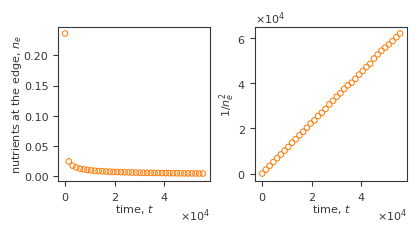

In [30]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize=(4.5,2))
fig.subplots_adjust(wspace=0.3)
#Plot the actual edge
#ax[0].scatter(data[ind]['time_snapshots'][::10],ne[::10], label=f' D = {D[ind]:.2f}')
ax[0].scatter(data[ind2]['time_snapshots'][::10],ne2[::10], color=colorsqrt)
#ax[0].plot(data[ind2]['time_snapshots'][::10],(data[ind2]['time_snapshots'][::10])**(-0.5)*H[ind2]**0.5*chi[ind2], label=f' D = {D[ind2]:.2f}')

#ax.scatter(data[ind3]['time_snapshots'][::10],(ne3[::10]**(-2)), label=f' D = {D[ind3]:.2f}')
ax[0].ticklabel_format(style='sci',scilimits =(0,0),axis='x',useMathText=True)
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'nutrients at the edge, $n_e$')
#ax[0].set_title("(a)",fontfamily='serif',loc='left')
#ax.set_xlim(0,data[ind3]['time_snapshots'][-1])
#ax[0].legend(loc='best')

# Plot 1/ne
#ax[1].scatter(data[ind]['time_snapshots'][::10],ne[::10]**(-2), label=f' D = {D[ind]:.2f}')
ax[1].scatter(data[ind2]['time_snapshots'][::10],ne2[::10]**(-2), color=colorsqrt)
#ax[1].plot(data[ind2]['time_snapshots'][::10],(data[ind2]['time_snapshots'][::10])/(H[ind2]*(chi[ind2]**2)), label=f' D = {D[ind2]:.2f}')
#ax.scatter(data[ind3]['time_snapshots'][::10],(ne3[::10]**(-2)), label=f' D = {D[ind3]:.2f}')
ax[1].ticklabel_format(style='sci',scilimits =(0,0),useMathText=True)
ax[1].set_xlabel(r'time, $t$')
ax[1].set_ylabel(r'$1/n_e^2$')
#ax[1].set_title("(b)",fontfamily='serif',loc='left')
#ax.set_xlim(0,data[ind3]['time_snapshots'][-1])
#ax[1].legend(loc='best')
#fig.savefig('./Figures/S2.pdf',format='pdf',bbox_inches='tight')

## Different models

In [31]:
#Find the simulation you want
query_param = {
    'method': 'monod',
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_Monod.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
dataMo=[];
for group_id in matches['group_id']:
    dataMo.append(NLDv3.load_simulation_data(group_id,saveFile='Monod.h5'))

Found runs:       L   BC   t0   Dn          Db  gamma  alpha method     K  beta   dt  \
0   500  Dir  0.0  1.0    0.010000      1      1  monod  0.05     1  0.0   
1   500  Dir  0.0  1.0    0.013738      1      1  monod  0.05     1  0.0   
2   500  Dir  0.0  1.0    0.018874      1      1  monod  0.05     1  0.0   
3   500  Dir  0.0  1.0    0.025929      1      1  monod  0.05     1  0.0   
4   500  Dir  0.0  1.0    0.035622      1      1  monod  0.05     1  0.0   
5   500  Dir  0.0  1.0    0.048939      1      1  monod  0.05     1  0.0   
6   500  Dir  0.0  1.0    0.067234      1      1  monod  0.05     1  0.0   
7   500  Dir  0.0  1.0    0.092367      1      1  monod  0.05     1  0.0   
8   500  Dir  0.0  1.0    0.126896      1      1  monod  0.05     1  0.0   
9   500  Dir  0.0  1.0    0.174333      1      1  monod  0.05     1  0.0   
10  500  Dir  0.0  1.0    0.239503      1      1  monod  0.05     1  0.0   
11  500  Dir  0.0  1.0    0.329034      1      1  monod  0.05     1  0.0   


In [32]:
#Find the simulation you want
query_param = {
    'method': 'maintenance',
    'L' : 500,
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_SM.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
dataM=[];
for group_id in matches['group_id']:
    dataM.append(NLDv3.load_simulation_data(group_id,saveFile='SM.h5'))

Found runs:       L   BC   t0   Dn          Db  gamma  alpha       method     K    nm  \
0   500  Dir  0.0  1.0    0.010000      1      1  maintenance  0.05  0.05   
1   500  Dir  0.0  1.0    0.013738      1      1  maintenance  0.05  0.05   
2   500  Dir  0.0  1.0    0.018874      1      1  maintenance  0.05  0.05   
3   500  Dir  0.0  1.0    0.025929      1      1  maintenance  0.05  0.05   
4   500  Dir  0.0  1.0    0.035622      1      1  maintenance  0.05  0.05   
5   500  Dir  0.0  1.0    0.048939      1      1  maintenance  0.05  0.05   
6   500  Dir  0.0  1.0    0.067234      1      1  maintenance  0.05  0.05   
7   500  Dir  0.0  1.0    0.092367      1      1  maintenance  0.05  0.05   
8   500  Dir  0.0  1.0    0.126896      1      1  maintenance  0.05  0.05   
9   500  Dir  0.0  1.0    0.174333      1      1  maintenance  0.05  0.05   
10  500  Dir  0.0  1.0    0.239503      1      1  maintenance  0.05  0.05   
11  500  Dir  0.0  1.0    0.329034      1      1  maintenance  0

In [33]:
#Find the simulation you want
query_param = {
    'method': 'diffusive3',
    'L' : 500
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_SM.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
dataD=[];
for group_id in matches['group_id']:
    dataD.append(NLDv3.load_simulation_data(group_id,saveFile='SM.h5'))

Found runs:       L   BC   t0   Dn   Db  gamma  alpha      method     K    nm  beta   dt  \
75  500  Dir  0.0  1.0  0.2      1      1  diffusive3  0.05  0.05     1  0.0   
76  500  Dir  0.0  1.0  3.0      1      1  diffusive3  0.05  0.05     1  0.0   

    accuracyX  accuracyT  n0                                param_hash  \
75       0.35       0.35   1  f0c5f9b9b2ac38e5e83d224c1d678922c094678a   
76       0.35       0.35   1  94c75e33f8c9da5302a9376697e041b270c8441f   

          timestamp                                           group_id  
75  20250916T163021  f0c5f9b9b2ac38e5e83d224c1d678922c094678a_20250...  
76  20250916T163344  94c75e33f8c9da5302a9376697e041b270c8441f_20250...  


In [34]:
#Find the simulation you want
query_param = {
    'beta': 2,
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_DLogspace_updated.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
dataB=[];
for group_id in matches['group_id']:
    dataB.append(NLDv3.load_simulation_data(group_id,saveFile='DLogspace.h5'))

Found runs:       L   BC  t0  Dn          Db  gamma  alpha  beta  dt  accuracyX  \
32  500  Dir   0   1    0.010000      1      1     2   0       0.35   
33  500  Dir   0   1    0.013738      1      1     2   0       0.35   
34  500  Dir   0   1    0.018874      1      1     2   0       0.35   
35  500  Dir   0   1    0.025929      1      1     2   0       0.35   
36  500  Dir   0   1    0.035622      1      1     2   0       0.35   
37  500  Dir   0   1    0.048939      1      1     2   0       0.35   
38  500  Dir   0   1    0.067234      1      1     2   0       0.35   
39  500  Dir   0   1    0.092367      1      1     2   0       0.35   
40  500  Dir   0   1    0.126896      1      1     2   0       0.35   
41  500  Dir   0   1    0.174333      1      1     2   0       0.35   
42  500  Dir   0   1    0.239503      1      1     2   0       0.35   
43  500  Dir   0   1    0.329034      1      1     2   0       0.35   
44  500  Dir   0   1    0.452035      1      1     2   0       0.

In [35]:
#Set up the D (same for all simulations):
D = np.zeros(len(dataMo))
for index,elem in enumerate(dataMo):
    D[index] = elem['param']['Db']

## Figure S1

Text(0.5, 0, 'position, x')

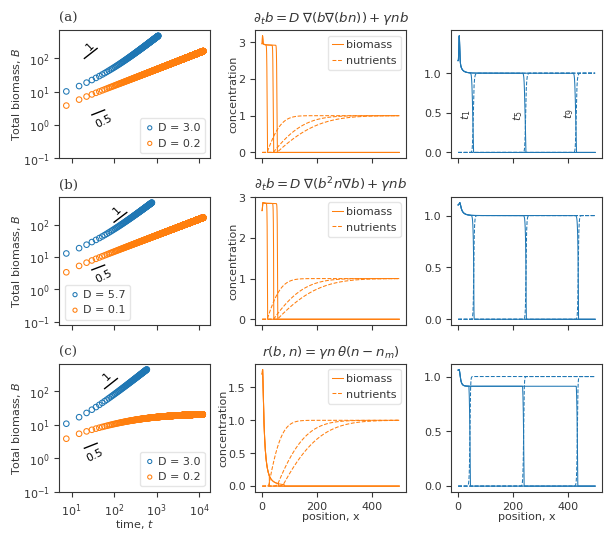

In [36]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7, 6),sharex='col')
fig.subplots_adjust(hspace=0.3,wspace=0.3)
# Diffusive model 4th row
Dd = np.zeros(len(dataD))
for index,elem in enumerate(dataD):
    Dd[index] = elem['param']['Db']
#Total biomass
ind1 = 0
ind2 = 1
slice1 = 5
slice2 = 5
ax[0,0].scatter(dataD[ind2]['time'][::slice2],dataD[ind2]['total_biomass'][::slice2],label=f"D = {Dd[ind2]}")
ax[0,0].scatter(dataD[ind1]['time'][::slice1],dataD[ind1]['total_biomass'][::slice1],label=f"D = {Dd[ind1]}")
add_slope_marker(ax[0,0], xy=(20, 100), slope=1, length_decades=0.3, text_offset=(-0.3, 0.1), text=r"1", color='k', lw=1)
add_slope_marker(ax[0,0], xy=(30, 2), slope=0.5, length_decades=0.3, text_offset=(-0.2, -0.7), text=r"0.5", color='k', lw=1)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
#ax.set_xlim(1,dataD[ind2]['time'][-1])
#ax.set_ylim(1,dataD[ind2]['total_biomass'][-1])
#ax[2,0].set_xlabel(r"time, in $1/(\gamma n_0)$")
ax[0,0].set_ylabel(r"Total biomass, $B$")
ax[2,0].set_xlabel(r"time, $t$")
ax[0,0].set_title("(a)",fontfamily='serif',loc='left')
ax[0,0].minorticks_off()
ax[0,0].legend()

#Profiles
#Plots of the profiles for biomass
xoffset=50
Np1 = len(dataD[ind1]['biomass_snapshots'])
Np2 = len(dataD[ind2]['biomass_snapshots'])
for i in [1,5,9]:
    # For ax[1,0]
    idx1 =  int(i *(Np1)/10)
    profile1 = dataD[ind1]['biomass_snapshots'][idx1]
    pos1 = dataD[ind1]['position']
    time1 = dataD[ind1]['time_snapshots'][idx1]
    
    max1 = dataD[ind1]['param']['n0']
    front_idx1 = np.where(profile1 < 0.5*max1)[0][0]
    x_label1 = pos1[front_idx1]-xoffset
    y_label1 = profile1[front_idx1]
    
    if i==1:
        ax[0,1].plot(pos1,profile1,color=colorsqrt,label=r'biomass')
        ax[0,1].plot(pos1,dataD[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed',label=r'nutrients')
    else:
        ax[0,1].plot(pos1,profile1,color=colorsqrt)
        ax[0,1].plot(pos1,dataD[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed')
    #ax[3,1].text(x_label1, y_label1, fr"$t_{i}$", rotation=90, va='center', ha='left')

    # For ax[1,1]
    idx2 = int(i * (Np2)/10)
    profile2 = dataD[ind2]['biomass_snapshots'][idx2]
    pos2 = dataD[ind2]['position']
    time2 = dataD[ind2]['time_snapshots'][idx2]

    max2 = dataD[ind2]['param']['n0']
    front_idx2 = np.where(profile2 < 0.5*max2)[0][0]
    x_label2 = pos2[front_idx2] -xoffset
    y_label2 = profile2[front_idx2]
    
    if i==1:
        ax[0,2].plot(pos2,profile2,color=colorlin,label=r'biomass')
        ax[0,2].plot(pos2,dataD[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed',label=r'nutrients')
    else:
        ax[0,2].plot(pos2,profile2,color=colorlin)
        ax[0,2].plot(pos2,dataD[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed')
    ax[0,2].text(x_label2, y_label2, f"$t_{i}$", rotation=90, va='center', ha='left')

    #ax.plot(data[ind]['position'],data[ind]['nutrient_snapshots'][-1])
#ax.set_xlim(0,100)
#ax[2,1].set_xlabel(r"position, x")
ax[0,1].legend(handlelength=1,handletextpad=0.2,loc='upper right')
#ax[1, 1].get_shared_y_axes().join(ax[1, 1], ax[1, 0])
ax[0,1].set_ylabel(r"concentration",labelpad=-0.2)
ax[0,1].set_title(r"$\partial_t b = D \: \nabla (b \nabla(b n)) + \gamma n b$",fontfamily='serif',loc='center')
#ax[0,2].set_xlabel(r"position, x")
#ax[0,1].set_xlabel(r"position, x")
#ax[3,2].legend(handlelength=1,handletextpad=0.2, loc='upper center')
ax[0,2].set_yticks([0,0.5,1])
#ax[3,2].set_ylabel(r"concentration",labelpad=-0.2)
#ax[3,2].set_title(f"(c)",fontfamily='serif',loc='left')



# beta=2 1th row
DB = np.zeros(len(dataB))
for index,elem in enumerate(dataB):
    DB[index] = elem['param']['Db']
#Total biomass
ind1 = 8
ind2 = 20
slice1 = 5
slice2 = 5
ax[1,0].scatter(dataB[ind2]['time'][::slice2],dataB[ind2]['total_biomass'][::slice2],label=f"D = {DB[ind2]:.1f}")
ax[1,0].scatter(dataB[ind1]['time'][::slice1],dataB[ind1]['total_biomass'][::slice1],label=f"D = {DB[ind1]:.1f}")
add_slope_marker(ax[1,0], xy=(100, 120), slope=1, length_decades=0.3, text_offset=(-0.4, 0.1), text=r"1", color='k', lw=1)
add_slope_marker(ax[1,0], xy=(30, 4), slope=0.5, length_decades=0.3, text_offset=(-0.2, -0.7), text=r"0.5", color='k', lw=1)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
#ax.set_xlim(1,dataD[ind2]['time'][-1])
#ax.set_ylim(1,dataD[ind2]['total_biomass'][-1])
ax[1,0].set_ylabel(r"Total biomass, $B$")
ax[1,0].set_title("(b)",fontfamily='serif',loc='left')
ax[1,0].minorticks_off()
ax[1,0].legend()
#Profiles
#Plots of the profiles for biomass
xoffset=50
Np1 = len(dataB[ind1]['biomass_snapshots'])
Np2 = len(dataB[ind2]['biomass_snapshots'])
for i in [1,5,9]:
    # For ax[1,0]
    idx1 = int(i * (Np1)/10)
    profile1 = dataB[ind1]['biomass_snapshots'][idx1]
    pos1 = dataB[ind1]['position']
    time1 = dataB[ind1]['time_snapshots'][idx1]
    
    max1 = dataB[ind1]['param']['n0']
    front_idx1 = np.where(profile1 <= 0.5*max1)[0][0]
    x_label1 = pos1[front_idx1]-xoffset
    y_label1 = profile1[front_idx1]
    
    if i==1:
        ax[1,1].plot(pos1,profile1,color=colorsqrt,label=r'biomass')
        ax[1,1].plot(pos1,dataB[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed',label=r'nutrients')
    else:
        ax[1,1].plot(pos1,profile1,color=colorsqrt)
        ax[1,1].plot(pos1,dataB[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed')
    #ax[0,1].text(x_label1, y_label1, fr"$t_{i}$", rotation=90, va='center', ha='left')

    # For ax[1,1]
    idx2 = int(i * (Np2)/10)
    profile2 = dataB[ind2]['biomass_snapshots'][idx2]
    pos2 = dataB[ind2]['position']
    time2 = dataB[ind2]['time_snapshots'][idx2]

    max2 = dataB[ind2]['param']['n0']
    front_idx2 = np.where(profile2 <= 0.5*max2)[0][0]
    x_label2 = pos2[front_idx2] -xoffset
    y_label2 = profile2[front_idx2]
    
    if i==1:
        ax[1,2].plot(pos2,profile2,color=colorlin,label=r'biomass')
        ax[1,2].plot(pos2,dataB[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed',label=r'nutrients')
    else:
        ax[1,2].plot(pos2,profile2,color=colorlin)
        ax[1,2].plot(pos2,dataB[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed')
    #ax[0,2].text(x_label2, y_label2, f"$t_{i}$", rotation=90, va='center', ha='left')

    #ax.plot(data[ind]['position'],data[ind]['nutrient_snapshots'][-1])
#ax.set_xlim(0,100)
#ax[1,1].set_xlabel(r"position, x")
ax[1,1].legend(handlelength=1,handletextpad=0.2,loc='upper right')
#ax[1, 1].get_shared_y_axes().join(ax[1, 1], ax[1, 0])
ax[1,1].set_ylabel(r"concentration",labelpad=-0.2)
ax[1,1].set_title(r"$\partial_t b = D \: \nabla (b^2 n \nabla b) + \gamma n b$",fontfamily='serif',loc='center')
#ax[1,2].set_xlabel(r"position, x")
#ax[0,2].legend(handlelength=1,handletextpad=0.2, loc='upper center')
ax[1,2].set_yticks([0,0.5,1])
#ax[0,2].set_ylabel(r"concentration",labelpad=-0.2)
#ax[0,2].set_title(f"(f)",fontfamily='serif',loc='left')




#Maintenance cost on 3th row
DM = np.zeros(len(dataM))
for index,elem in enumerate(dataM):
    DM[index] = elem['param']['Db']
ind1 = -2
ind2 = -1
slice1 = 5
slice2 = 5
#Total biomass
ax[2,0].scatter(dataM[ind2]['time'][::slice2],dataM[ind2]['total_biomass'][::slice2],label=f"D = {DM[ind2]}")
ax[2,0].scatter(dataM[ind1]['time'][::slice1],dataM[ind1]['total_biomass'][::slice1],label=f"D = {DM[ind1]}")
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
add_slope_marker(ax[2,0], xy=(60, 120), slope=1, length_decades=0.3, text_offset=(-0.4, 0.1), text=r"1", color='k', lw=1)
add_slope_marker(ax[2,0], xy=(20, 2), slope=0.5, length_decades=0.3, text_offset=(-0.3, -0.7), text=r"0.5", color='k', lw=1)
#ax[2,0].set_ylim(1,dataM[ind2]['total_biomass'][-1])
ax[2,0].set_ylabel(r"Total biomass, $B$")
ax[2,0].set_title("(c)",fontfamily='serif',loc='left')
ax[2,0].minorticks_off()
ax[2,0].legend()


#Profiles
#Plots of the profiles for biomass
xoffset=50
Np1 = len(dataM[ind1]['biomass_snapshots'])
Np2 = len(dataM[ind2]['biomass_snapshots'])
for i in [1,5,9]:
    # For ax[1,1]
    idx1 =  int(i *(Np1-1)/10)
    profile1 = dataM[ind1]['biomass_snapshots'][idx1]
    pos1 = dataM[ind1]['position']
    time1 = dataM[ind1]['time_snapshots'][idx1]
    
    max1 = dataM[ind1]['param']['n0']
    front_idx1 = np.where(profile1 < 0.5*max1)[0][0]
    x_label1 = pos1[front_idx1]-xoffset
    y_label1 = profile1[front_idx1]
    
    if i==1:
        ax[2,1].plot(pos1,profile1,color=colorsqrt,label=r'biomass')
        ax[2,1].plot(pos1,dataM[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed',label=r'nutrients')
    else:
        ax[2,1].plot(pos1,profile1,color=colorsqrt)
        ax[2,1].plot(pos1,dataM[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed')
    #ax[2,1].text(x_label1, y_label1, fr"$t_{i}$", rotation=90, va='center', ha='left')

    # For ax[1,0]
    idx2 =  int(i *(Np2-1)/10)
    profile2 = dataM[ind2]['biomass_snapshots'][idx2]
    pos2 = dataM[ind2]['position']
    time2 = dataM[ind2]['time_snapshots'][idx2]

    max2 = dataM[ind2]['param']['n0']
    front_idx2 = np.where(profile2 < 0.5*max2)[0][0]
    x_label2 = pos2[front_idx2] -xoffset
    y_label2 = profile2[front_idx2]
    
    if i==1:
        ax[2,2].plot(pos2,profile2,color=colorlin,label=r'biomass')
        ax[2,2].plot(pos2,dataM[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed',label=r'nutrients')
    else:
        ax[2,2].plot(pos2,profile2,color=colorlin)
        ax[2,2].plot(pos2,dataM[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed')
    #ax[2,2].text(x_label2, y_label2, f"$t_{i}$", rotation=90, va='center', ha='left')

    #ax.plot(data[ind]['position'],data[ind]['nutrient_snapshots'][-1])
#ax.set_xlim(0,100)
ax[2,1].set_xlabel(r"position, x")
ax[2,1].legend(handlelength=1,handletextpad=0.2,loc='upper right')
ax[2,1].set_ylabel(r"concentration",labelpad=-0.2)
ax[2,1].set_title(r"$r(b,n) = \gamma n \: \theta (n-n_m)$",fontfamily='serif',loc='center')
#ax[2,2].legend(handlelength=1,handletextpad=0.2, loc='upper center')
ax[2,2].set_yticks([0,0.5,1])
ax[2,2].set_xlabel(r"position, x")
#ax[2,2].set_ylabel(r"concentration",labelpad=-0.2)

#ax[1, 1].get_shared_y_axes().join(ax[1, 1], ax[1, 0])
#ax[2,2].set_title(f"(l)",loc='left')



#fig.savefig('./Figures/S1.pdf',format='pdf',bbox_inches='tight',pad_inches=0)

## Zoom on the profiles for nutrients and biomass in the two different cases

Text(0, 0.5, 'concentration')

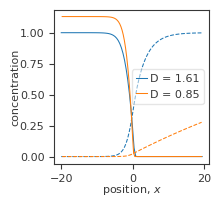

In [37]:
# Figures that centers around the front position for the biomass and nutrient profiles
ind1 = 16 # Which data of Db needs to be plotted
time_stamp1 = int(len(data[ind1]['biomass_snapshots'])/2)
front_pos1 = data[ind1]['front_position'][10*time_stamp1]
dx1 = (data[ind1]['position'][2]-data[ind1]['position'][1])
Npoints1 = int(20/dx1) #Number of points around the front position
front_pos_ind1 = int(front_pos1/dx1)

ind2 = 14 # Which data of Db needs to be plotted
time_stamp2 = int(len(data[ind2]['biomass_snapshots'])/2)
front_pos2 = data[ind2]['front_position'][10*time_stamp2]
dx2 = (data[ind2]['position'][2]-data[ind2]['position'][1])
Npoints2 = int(20/dx2) #Number of points around the front position
front_pos_ind2 = int(front_pos2/dx2)

fig,ax = plt.subplots(figsize=(2,2))

ax.plot(data[ind1]['position'][front_pos_ind1-Npoints1:front_pos_ind1+Npoints1]-front_pos1,data[ind1]['biomass_snapshots'][time_stamp1][front_pos_ind1-Npoints1:front_pos_ind1+Npoints1],color=colorlin,label=f"D = {data[ind1]['param']['Db']:.2f}")
ax.plot(data[ind1]['position'][front_pos_ind1-Npoints1:front_pos_ind1+Npoints1]-front_pos1,data[ind1]['nutrient_snapshots'][time_stamp1][front_pos_ind1-Npoints1:front_pos_ind1+Npoints1],color=colorlin,linestyle='dashed')
ax.plot(data[ind2]['position'][front_pos_ind2-Npoints2:front_pos_ind2+Npoints2]-front_pos2,data[ind2]['biomass_snapshots'][time_stamp2][front_pos_ind2-Npoints2:front_pos_ind2+Npoints2],color=colorsqrt,label=f"D = {data[ind2]['param']['Db']:.2f}")
ax.plot(data[ind2]['position'][front_pos_ind2-Npoints2:front_pos_ind2+Npoints2]-front_pos2,data[ind2]['nutrient_snapshots'][time_stamp2][front_pos_ind2-Npoints2:front_pos_ind2+Npoints2],color=colorsqrt,linestyle='dashed')
ax.legend()
ax.set_xlabel(r'position, $x$')
ax.set_ylabel('concentration')

#fig.savefig('./Figures/zoom_profiles.pdf',format='pdf',bbox_inches='tight',pad_inches=0)

## Nutrient-independent model

In [38]:
# Load the data
#Find the simulation you want
query_param = {
    'alpha' :0,
    'L' : 3000
}

#Identify all the matches with those parameters and print their IDs
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_revisions.csv")
print("Found runs:", matches)

# Load and use the simulation data for each run
data_nn=[];
for group_id in matches['group_id']:
    data_nn.append(NLDv3.load_simulation_data(group_id,saveFile='revisions.h5'))

Found runs:          L   BC   t0   Dn        Db  gamma  alpha  method     K    nm  beta  \
15  3000.0  Dir  0.0  1.0  1.000000      1      0  linear  0.05  0.05     1   
16  3000.0  Dir  0.0  1.0  0.784760      1      0  linear  0.05  0.05     1   
17  3000.0  Dir  0.0  1.0  0.615848      1      0  linear  0.05  0.05     1   
19  3000.0  Dir  0.0  1.0  0.483293      1      0  linear  0.05  0.05     1   
20  3000.0  Dir  0.0  1.0  0.379269      1      0  linear  0.05  0.05     1   
22  3000.0  Dir  0.0  1.0  0.297635      1      0  linear  0.05  0.05     1   
24  3000.0  Dir  0.0  1.0  0.233572      1      0  linear  0.05  0.05     1   
27  3000.0  Dir  0.0  1.0  0.183298      1      0  linear  0.05  0.05     1   
29  3000.0  Dir  0.0  1.0  0.143845      1      0  linear  0.05  0.05     1   
31  3000.0  Dir  0.0  1.0  0.112884      1      0  linear  0.05  0.05     1   
34  3000.0  Dir  0.0  1.0  0.088587      1      0  linear  0.05  0.05     1   
36  3000.0  Dir  0.0  1.0  0.069519     

In [39]:
data_nn = sorted(data_nn, key=lambda x: x['param']['Db'])

In [40]:
D_nn = np.zeros(len(data_nn))
for index,elem in enumerate(data_nn):
    D_nn[index] = elem['param']['Db']

In [41]:
edgefit_data_nn = NLDv3.edgefit_dataset(data_nn,min_len=0.7,r2_threshold=0.9)
linear_edgefit_data_nn = NLDv3.linear_edgefit_dataset(data_nn,min_len=0.7,r2_threshold=0.9)

In [42]:
#Unpack the data
#1d data
V_nn = np.zeros(len(linear_edgefit_data_nn))
R22_nn = np.zeros(len(linear_edgefit_data_nn))
for index,elem in enumerate(linear_edgefit_data_nn):
    V_nn[index] = elem['xi']
    R22_nn[index] = elem['r2']
chi_nn = np.zeros(len(edgefit_data_nn))
R2_nn = np.zeros(len(edgefit_data_nn))
for index,elem in enumerate(edgefit_data_nn):
    chi_nn[index] = elem['xi']/2
    R2_nn[index] = elem['r2']

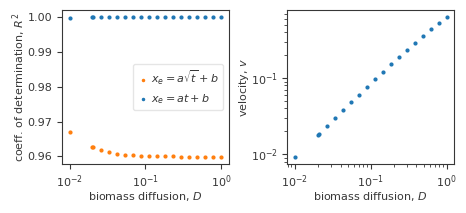

In [44]:
#Plot of R2 in the linear and quadratic regimes
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(3.375*1.5,2))
fig.subplots_adjust(wspace=0.35)
#spline = make_interp_spline(D_nn, R2_nn, k=11)
#spline2 = make_interp_spline(D_nn, R22_nn, k=11)
# Generate smooth x (higher resolution)
#x_smooth = np.linspace(D_nn.min(), D_nn.max(), 500)
#y_smooth1 = spline(x_smooth)
#y_smooth2 = spline2(x_smooth)
ax[0].scatter(D_nn, R2_nn,label=r'$x_e = a\sqrt{t}+b$',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorsqrt)
ax[0].scatter(D_nn,R22_nn,label=r'$x_e = at+b$',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorlin)


#ax[0,1].plot(x_smooth,y_smooth1,color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth2,color=colorsqrt)
#ax.plot(D,spline(D),color=colorsqrt)
#ax.plot(D,spline2(D),color=colorlin)

ax[0].legend()
ax[0].set_xlabel(r'biomass diffusion, $D$')
ax[0].set_ylabel(r'coeff. of determination, $R^2$')
ax[0].set_xscale('log')
ax[0].minorticks_off()
ax[0].set_xticks([0.01,0.1,1])


ax[1].scatter(D_nn,V_nn,marker=MarkerStyle(marker='.', fillstyle='full'))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'biomass diffusion, $D$')
#ax[1].minorticks_off()
ax[1].set_xticks([0.01,0.1,1])
ax[1].set_ylabel(r'velocity, $v$')
#ax.legend()
#fig.savefig('./Figures/nutrient_independent.pdf',format='pdf',bbox_inches='tight')

Text(0, 0.5, 'velocity, $v$')

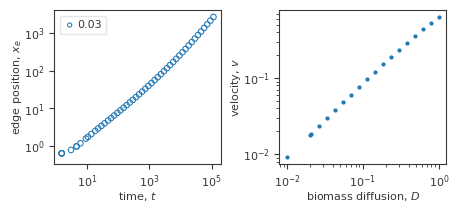

In [45]:
#Plot of biomass edge and velocity as a function of D
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(3.375*1.5,2))
fig.subplots_adjust(wspace=0.35)
#spline = make_interp_spline(D_nn, R2_nn, k=11)
#spline2 = make_interp_spline(D_nn, R22_nn, k=11)
# Generate smooth x (higher resolution)
#x_smooth = np.linspace(D_nn.min(), D_nn.max(), 500)
#y_smooth1 = spline(x_smooth)
#y_smooth2 = spline2(x_smooth)
ind=3

Nplot=50
time1 = data_nn[ind]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1)

ax[0].scatter(data_nn[ind]['time'][indices1],data_nn[ind]['front_position'][indices1],color=colorlin,label=f"{data_nn[ind]['param']['Db']:.2f}")
#ax[0,1].plot(x_smooth,y_smooth1,color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth2,color=colorsqrt)
#ax.plot(D,spline(D),color=colorsqrt)
#ax.plot(D,spline2(D),color=colorlin)

ax[0].legend()
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'edge position, $x_e$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_off()
#ax[0].set_xticks([0.01,0.1,1])


ax[1].scatter(D_nn,V_nn,marker=MarkerStyle(marker='.', fillstyle='full'))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'biomass diffusion, $D$')
#ax[1].minorticks_off()
#ax[1].set_xticks([0.01,0.1,1])
ax[1].set_ylabel(r'velocity, $v$')
#ax.legend()
#fig.savefig('./Figures/nutrient_independent.pdf',format='pdf',bbox_inches='tight')

## Size increase of the depletion layer

In [46]:
def compute_depletion_layer(b_array, n_array, dx, threshold_edge,threshold_nutrients):
    """ Computes the nutrient density at where the biomass reaches the threshold value at the edge. """
    xe = NLDv3.compute_front(b_array, dx, threshold_edge)
    indices = np.where(n_array >= threshold_nutrients)[0] # finds all indices where the biomass is greater than or equal to the threshold

    if len(indices) == 0: # if the threshold is not meant it returns not a number
        print("Warning: Too close to the edge.")
        return np.nan
    i = indices[0] # the first index where the nutrients is greater than the threshold close to full nutrients
    return i*dx-xe

In [47]:
#Computes nutrient at the edge for D<D_C
ind=0
ind2 = 1
de = np.zeros(len(data_long[ind]['time_snapshots']))
de2 = np.zeros(len(data_long[ind2]['time_snapshots']))
params = data_long[ind]['param']
dx = params['accuracyX']*(params['Db']*params['n0']/params['gamma'])**0.5
params2 = data_long[ind2]['param']
dx2 = params2['accuracyX']*(params2['Db']*params2['n0']/params2['gamma'])**0.5
threshold_edge = 0.1*params['n0']
threshold_nutrients = 0.98*params['n0']
for i in range(len(data_long[ind]['time_snapshots'])):
    de[i] = compute_depletion_layer(data_long[ind]['biomass_snapshots'][i], data_long[ind]['nutrient_snapshots'][i], dx, threshold_edge,threshold_nutrients)
for i in range(len(data_long[ind2]['time_snapshots'])):
    de2[i] = compute_depletion_layer(data_long[ind2]['biomass_snapshots'][i], data_long[ind2]['nutrient_snapshots'][i], dx2, threshold_edge,threshold_nutrients)

Text(0, 0.5, '$L_\\text{depletion}/L$')

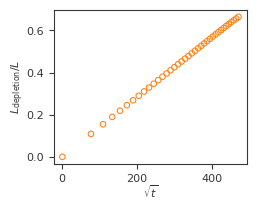

In [48]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(2.5,2))
ax.scatter(data_long[ind]['time_snapshots'][:-4000:400]**0.5,de[:-4000:400]/params['L'],color=colorsqrt)
ax.set_xlabel(r'$\sqrt{t}$')
ax.set_ylabel(r'$L_\text{depletion}/L$')
#ax[1].scatter(data_long[ind2]['time_snapshots'][::10],de2[::10],color=colorlin)
#fig.savefig('./Figures/depletion_layer_sqrt.pdf',format='pdf',bbox_inches='tight')

## Distance to the edge

In [49]:
#Finding the appropriate simulations
query_param = {
    'Db': 0.5
    
}
"""
query_param2 = {
    'L': 1000,
    'Db': 0.23
}

query_param3 = {
    'L': 500,
    'Db': 0.23
}
"""
matches = NLDv3.find_simulations_by_param(query_param, csvFile = "lookup_revisions.csv")
print("Found runs:", matches)
"""
#Identify all the matches with those parameters and print their IDs
matches2 = NLDv3.find_simulations_by_param(query_param2, csvFile = "lookup_DLogspace_updated.csv")
print("Found runs:", matches2)

#Identify all the matches with those parameters and print their IDs
matches3 = NLDv3.find_simulations_by_param(query_param3, csvFile = "lookup_DLogspace_updated.csv")
print("Found runs:", matches3)
"""
# Load and use the simulation data for each run
data_lenght=[];
for group_id in matches['group_id']:
    data_lenght.append(NLDv3.load_simulation_data(group_id,saveFile='revisions.h5'))
"""
# Load and use the simulation data for each run
for group_id in matches2['group_id']:
    data_lenght.append(NLDv3.load_simulation_data(group_id,saveFile='DLogspace.h5'))

# Load and use the simulation data for each run
for group_id in matches3['group_id']:
    data_lenght.append(NLDv3.load_simulation_data(group_id,saveFile='DLogspace.h5'))
"""
data_lenght = sorted(data_lenght, key=lambda x: x['param']['L'])

Found runs:               L   BC   t0   Dn   Db  gamma  alpha  method     K    nm  beta  \
18  1000.000000  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
21  1111.111111  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
23  1222.222222  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
25  1333.333333  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
26  1444.444444  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
28  1555.555556  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
30  1666.666667  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
32  1777.777778  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
33  1888.888889  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   
35  2000.000000  Dir  0.0  1.0  0.5      1      1  linear  0.05  0.05     1   

     dt  accuracyX  accuracyT  n0                                param_hash  \
18  0.0       0.35       0.35   1  7f9c

In [50]:
#Compute the distance to the edge of the simulation box for each lengths
EndDist = np.zeros(len(data_lenght))
EndDist_frac = np.zeros(len(data_lenght))
L = np.zeros(len(data_lenght))
for index,elems in enumerate(data_lenght):
    xe = elems['front_position'][-1]
    L[index] = elems['param']['L']
    EndDist[index] = (L[index]-xe)#/L[index] #xe/L[index] # (L[index]-xe)/L[index]
    EndDist_frac[index] = (L[index]-xe)/L[index]

Text(0.0, 1.0, '(b)')

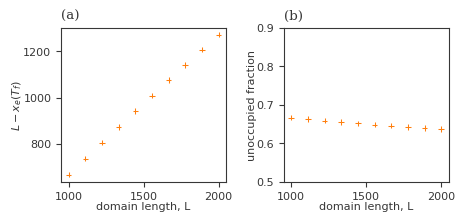

In [51]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(5,2))
fig.subplots_adjust(wspace=0.35)
ax[0].scatter(L,EndDist,marker='+',color=colorsqrt)
ax[0].set_xlabel(r'domain length, L')
ax[0].set_ylabel(r'$L-x_e(T_f)$')
ax[0].set_title('(a)',fontfamily='serif',loc='left')
ax[1].scatter(L,EndDist_frac,marker='+',color=colorsqrt)
ax[1].set_xlabel(r'domain length, L')
ax[1].set_ylabel(r'unoccupied fraction')
ax[1].set_ylim(0.5,0.9)
ax[1].set_title('(b)',fontfamily='serif',loc='left')
#fig.savefig('./Figures/distanceEdge.pdf',format='pdf',bbox_inches='tight')

## Profiles in 1D

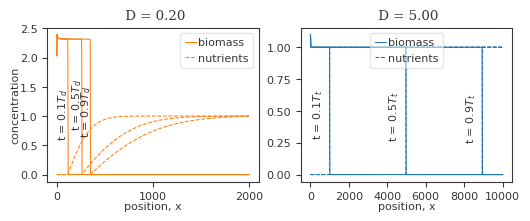

In [52]:
#Plots of the profiles for biomass
ind1 = 0
ind2 = 1
fig,ax1 = plt.subplots(nrows=1,ncols=2,figsize=(6,2))
xoffset=120
Np1 = len(data_long[ind1]['biomass_snapshots'])
Np2 = len(data_long[ind2]['biomass_snapshots'])
for i in [1,5,9]:
    # For ax[1,1]
    idx1 = i * int((Np1-1)/10)
    profile1 = data_long[ind1]['biomass_snapshots'][idx1]
    pos1 = data_long[ind1]['position']
    time1 = data_long[ind1]['time_snapshots'][idx1]
    
    max1 = np.max(profile1)
    front_idx1 = np.where(profile1 < 0.5*max1)[0][0]
    x_label1 = pos1[front_idx1]-xoffset
    y_label1 = profile1[front_idx1]
    
    if i==1:
        ax1[0].plot(pos1,profile1,color=colorsqrt,label=r'biomass')
        ax1[0].plot(pos1,data_long[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed',label=r'nutrients')
    else:
        ax1[0].plot(pos1,profile1,color=colorsqrt)
        ax1[0].plot(pos1,data_long[ind1]['nutrient_snapshots'][idx1],color=colorsqrt,linestyle='dashed')
    ax1[0].text(x_label1, y_label1, fr"t = 0.{i}$T_d$", rotation=90, va='center', ha='left')

    # For ax[1,0]
    idx2 = i * int((Np2-1)/10)
    profile2 = data_long[ind2]['biomass_snapshots'][idx2]
    pos2 = data_long[ind2]['position']
    time2 = data_long[ind2]['time_snapshots'][idx2]

    max2 = np.max(profile2)
    front_idx2 = np.where(profile2 < 0.5*max2)[0][0]
    x_label2 = pos2[front_idx2] -8*xoffset
    y_label2 = profile2[front_idx2]
    
    if i==1:
        ax1[1].plot(pos2,profile2,color=colorlin,label=r'biomass')
        ax1[1].plot(pos2,data_long[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed',label=r'nutrients')
    else:
        ax1[1].plot(pos2,profile2,color=colorlin)
        ax1[1].plot(pos2,data_long[ind2]['nutrient_snapshots'][idx2],color=colorlin,linestyle='dashed')
    ax1[1].text(x_label2, y_label2, f"t = 0.{i}$T_t$", rotation=90, va='center', ha='left')

    #ax.plot(data[ind]['position'],data[ind]['nutrient_snapshots'][-1])
#ax.set_xlim(0,100)
ax1[0].set_xlabel(r"position, x")
ax1[1].set_xlabel(r"position, x")
ax1[1].legend(handlelength=1,handletextpad=0.2, loc='upper center')
ax1[0].legend(handlelength=1,handletextpad=0.2,loc='upper right')
#ax[1, 1].get_shared_y_axes().join(ax[1, 1], ax[1, 0])
ax1[0].set_ylabel(r"concentration",labelpad=-0.2)
ax1[1].set_title(f" D = {data_long[ind2]['param']['Db']:.2f}",fontfamily='serif',loc='center')
ax1[0].set_title(f" D = {data_long[ind1]['param']['Db']:.2f}",fontfamily='serif',loc='center')
ax1[0].set_xticks([0,1000,2000])
#ax1[1].set_xticks([0,250,500,750,1000])

## 1d vs 2d simulations

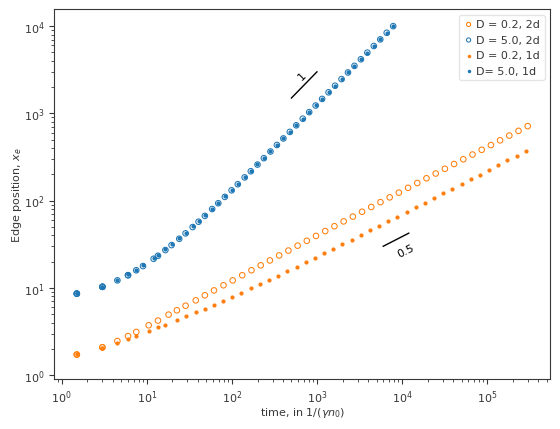

In [53]:
#Edge position on log scale
fig,ax=plt.subplots()
ind1=0
ind2=1

Nplot = 50
time1 = data2d_long[ind1]['time']
time2 = data2d_long[ind2]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
mask2 = time2 > 0
time2 = time2[mask2]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
log_times2 = np.logspace(np.log10(time2.min()), np.log10(time2.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1)
indices2 = np.searchsorted(time2, log_times2)


#Select points to plot on a log-scale so it looks pretty
slice1 = 5
slice2 = 5
#Plot the 2d data
ax.scatter(data2d_long[ind1]['time'][indices1],data2d_long[ind1]['front_position'][indices1],marker='o',color=colorsqrt,label=f"D = {data2d_long[ind1]['param']['Db']:.1f}, 2d")
ax.scatter(data2d_long[ind2]['time'][indices2],data2d_long[ind2]['front_position'][indices2],marker='o',color=colorlin,label=f"D = {data2d_long[ind2]['param']['Db']:.1f}, 2d")

#Plot the 1d data
time1 = data_long[ind1]['time']
time2 = data_long[ind2]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
mask2 = time2 > 0
time2 = time2[mask2]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
log_times2 = np.logspace(np.log10(time2.min()), np.log10(time2.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1)
indices2 = np.searchsorted(time2, log_times2)
ax.scatter(data_long[ind1]['time'][indices1],data_long[ind1]['front_position'][indices1],marker=MarkerStyle(marker='.', fillstyle='full'),color=colorsqrt,label=f"D = {data_long[ind1]['param']['Db']:.1f}, 1d")
ax.scatter(data_long[ind2]['time'][indices2],data_long[ind2]['front_position'][indices2],marker=MarkerStyle(marker='.', fillstyle='full'),color=colorlin,label=f"D= {data_long[ind2]['param']['Db']:.1f}, 1d")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(10,data2d[ind2]['time'][-1])
#ax.set_ylim(10,data2d[ind2]['total_biomass'][-1])
ax.set_xlabel(r"time, in $1/(\gamma n_0)$")
ax.set_ylabel(r"Edge position, $x_e$")
# ----------- Add power-law reference lines -------------
add_slope_marker(ax, xy=(500, 1500), slope=1, length_decades=0.3, text_offset=(-0.2, 0.1), text=r"1", color='k', lw=1)
add_slope_marker(ax, xy=(6000, 30), slope=0.5, length_decades=0.3, text_offset=(-0.0, -0.4), text=r"0.5", color='k', lw=1)

# Custom legend handles
color_legend_elements = [
    Line2D([0], [0], marker='.', color='w',markerfacecolor=colorsqrt,markersize=8,label=r'$0.2$',fillstyle='full'),
    Line2D([0], [0], marker='.', color='w', markerfacecolor=colorlin,markersize=8, label=r'$5$',fillstyle='full')
]
marker_legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='1D', linestyle='None'),
    Line2D([0], [0], marker='*', color='k', label='2D', linestyle='None')
]
# Place legends
#color_legend = ax.legend(handles=color_legend_elements, loc='upper left',title=r'$D$')
#marker_legend = ax.legend(handles=marker_legend_elements, loc='center left')
#ax.add_artist(color_legend) 
ax.legend()
#legend.set_title(r'$D$')
#fig.savefig('./Figures/EdgePosition_12D.pdf',format='pdf',bbox_inches='tight')

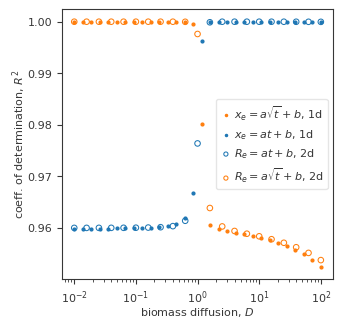

In [54]:
#Plot of R2 in the linear and quadratic regimes
fig,ax = plt.subplots(figsize=(3.5,3.5))

spline = make_interp_spline(D, R2, k=11)
spline2 = make_interp_spline(D, R22, k=11)
# Generate smooth x (higher resolution)
x_smooth = np.linspace(D.min(), D.max(), 500)
y_smooth1 = spline(x_smooth)
y_smooth2 = spline2(x_smooth)
ax.scatter(D, R2,label=r'$x_e = a\sqrt{t}+b$, 1d',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorsqrt)
ax.scatter(D,R22,label=r'$x_e = at+b$, 1d',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth1,color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth2,color=colorsqrt)
#ax.plot(D,spline(D),color=colorsqrt)
#ax.plot(D,spline2(D),color=colorlin)

spline2d = make_interp_spline(D2d, R2_2d, k=11)
spline22d = make_interp_spline(D2d, R22_2d, k=11)
# Generate smooth x (higher resolution)
x_smooth2d = np.linspace(D2d.min(), D2d.max(), 500)
y_smooth12d = spline(x_smooth2d)
y_smooth22d = spline2(x_smooth2d)
ax.scatter(D2d, R22_2d,label=r'$R_e = at+b$, 2d',color=colorlin,marker='o')
ax.scatter(D2d,R2_2d,label=r'$R_e = a\sqrt{t}+b$, 2d',color=colorsqrt,marker='o')

# Custom legend handles
color_legend_elements = [
    Line2D([0], [0], marker='.', color='w',markerfacecolor=colorsqrt,markersize=8,label=r'$x_e = a\sqrt{t}+b$',fillstyle='full'),
    Line2D([0], [0], marker='.', color='w', markerfacecolor=colorlin,markersize=8, label=r'$x_e = a\:t+b$',fillstyle='full')
]
marker_legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='1D', linestyle='None'),
    Line2D([0], [0], marker='*', color='k', label='2D', linestyle='None')
]

# Place legends
#color_legend = ax.legend(handles=color_legend_elements, loc='center left')
#marker_legend = ax.legend(handles=marker_legend_elements, loc='center right')
#ax.add_artist(color_legend) 

ax.legend()
ax.set_xlabel(r'biomass diffusion, $D$')
ax.set_ylabel(r'coeff. of determination, $R^2$')
#ax.plot(D2d,spline2d(D2d),color=colorlin)
#ax.plot(D2d,spline22d(D2d),color=colorsqrt)
ax.set_xscale('log')
#ax.legend()
#fig.savefig('./Figures/R2_frontposition_test.pdf',format='pdf',bbox_inches='tight')

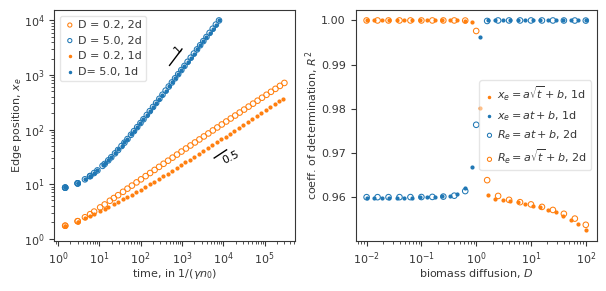

In [55]:
#Edge position and R^2 fitting on same plot for 1 and 2d, for the supplement

#Edge position on log scale
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(7,3))
fig.subplots_adjust(wspace=0.25)
ind1=0
ind2=1

Nplot = 50
time1 = data2d_long[ind1]['time']
time2 = data2d_long[ind2]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
mask2 = time2 > 0
time2 = time2[mask2]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
log_times2 = np.logspace(np.log10(time2.min()), np.log10(time2.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1)
indices2 = np.searchsorted(time2, log_times2)


#Select points to plot on a log-scale so it looks pretty
slice1 = 5
slice2 = 5
#Plot the 2d data
ax[0].scatter(data2d_long[ind1]['time'][indices1],data2d_long[ind1]['front_position'][indices1],marker='o',color=colorsqrt,label=f"D = {data2d_long[ind1]['param']['Db']:.1f}, 2d")
ax[0].scatter(data2d_long[ind2]['time'][indices2],data2d_long[ind2]['front_position'][indices2],marker='o',color=colorlin,label=f"D = {data2d_long[ind2]['param']['Db']:.1f}, 2d")

#Plot the 1d data
time1 = data_long[ind1]['time']
time2 = data_long[ind2]['time']
mask1 = time1 > 0 #Have to make sure not to include 0 for log...
time1 = time1[mask1]
mask2 = time2 > 0
time2 = time2[mask2]
log_times1 = np.logspace(np.log10(time1.min()), np.log10(time1.max()), Nplot)
log_times2 = np.logspace(np.log10(time2.min()), np.log10(time2.max()), Nplot)
indices1 = np.searchsorted(time1, log_times1)
indices2 = np.searchsorted(time2, log_times2)
ax[0].scatter(data_long[ind1]['time'][indices1],data_long[ind1]['front_position'][indices1],marker=MarkerStyle(marker='.', fillstyle='full'),color=colorsqrt,label=f"D = {data_long[ind1]['param']['Db']:.1f}, 1d")
ax[0].scatter(data_long[ind2]['time'][indices2],data_long[ind2]['front_position'][indices2],marker=MarkerStyle(marker='.', fillstyle='full'),color=colorlin,label=f"D= {data_long[ind2]['param']['Db']:.1f}, 1d")

ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax.set_xlim(10,data2d[ind2]['time'][-1])
#ax.set_ylim(10,data2d[ind2]['total_biomass'][-1])
ax[0].set_xlabel(r"time, in $1/(\gamma n_0)$")
ax[0].set_ylabel(r"Edge position, $x_e$")
# ----------- Add power-law reference lines -------------
add_slope_marker(ax[0], xy=(500, 1500), slope=1, length_decades=0.3, text_offset=(-0.2, 0.1), text=r"1", color='k', lw=1)
add_slope_marker(ax[0], xy=(6000, 30), slope=0.5, length_decades=0.3, text_offset=(-0.0, -0.4), text=r"0.5", color='k', lw=1)

# Custom legend handles
color_legend_elements = [
    Line2D([0], [0], marker='.', color='w',markerfacecolor=colorsqrt,markersize=8,label=r'$0.2$',fillstyle='full'),
    Line2D([0], [0], marker='.', color='w', markerfacecolor=colorlin,markersize=8, label=r'$5$',fillstyle='full')
]
marker_legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='1D', linestyle='None'),
    Line2D([0], [0], marker='*', color='k', label='2D', linestyle='None')
]
# Place legends
#color_legend = ax.legend(handles=color_legend_elements, loc='upper left',title=r'$D$')
#marker_legend = ax.legend(handles=marker_legend_elements, loc='center left')
#ax.add_artist(color_legend) 
ax[0].legend()

spline = make_interp_spline(D, R2, k=11)
spline2 = make_interp_spline(D, R22, k=11)
# Generate smooth x (higher resolution)
x_smooth = np.linspace(D.min(), D.max(), 500)
y_smooth1 = spline(x_smooth)
y_smooth2 = spline2(x_smooth)
ax[1].scatter(D, R2,label=r'$x_e = a\sqrt{t}+b$, 1d',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorsqrt)
ax[1].scatter(D,R22,label=r'$x_e = at+b$, 1d',marker=MarkerStyle(marker='.', fillstyle='full'),color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth1,color=colorlin)
#ax[0,1].plot(x_smooth,y_smooth2,color=colorsqrt)
#ax.plot(D,spline(D),color=colorsqrt)
#ax.plot(D,spline2(D),color=colorlin)

spline2d = make_interp_spline(D2d, R2_2d, k=11)
spline22d = make_interp_spline(D2d, R22_2d, k=11)
# Generate smooth x (higher resolution)
x_smooth2d = np.linspace(D2d.min(), D2d.max(), 500)
y_smooth12d = spline(x_smooth2d)
y_smooth22d = spline2(x_smooth2d)
ax[1].scatter(D2d, R22_2d,label=r'$R_e = at+b$, 2d',color=colorlin,marker='o')
ax[1].scatter(D2d,R2_2d,label=r'$R_e = a\sqrt{t}+b$, 2d',color=colorsqrt,marker='o')

# Custom legend handles
color_legend_elements = [
    Line2D([0], [0], marker='.', color='w',markerfacecolor=colorsqrt,markersize=8,label=r'$x_e = a\sqrt{t}+b$',fillstyle='full'),
    Line2D([0], [0], marker='.', color='w', markerfacecolor=colorlin,markersize=8, label=r'$x_e = a\:t+b$',fillstyle='full')
]
marker_legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='1D', linestyle='None'),
    Line2D([0], [0], marker='*', color='k', label='2D', linestyle='None')
]

# Place legends
#color_legend = ax.legend(handles=color_legend_elements, loc='center left')
#marker_legend = ax.legend(handles=marker_legend_elements, loc='center right')
#ax.add_artist(color_legend) 

ax[1].legend()
ax[1].set_xlabel(r'biomass diffusion, $D$')
ax[1].set_ylabel(r'coeff. of determination, $R^2$')
#ax.plot(D2d,spline2d(D2d),color=colorlin)
#ax.plot(D2d,spline22d(D2d),color=colorsqrt)
ax[1].set_xscale('log')
#fig.savefig('./Figures/EdgeR2_frontposition_12d.pdf',format='pdf',bbox_inches='tight')